In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
######## 读取数据 ########
sheet = pd.read_excel('data_input/美国10年通胀预期Trend_F0.1.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
sheet = sheet.reset_index().rename(columns={'index': 'Date'})
sheet.tail()

,Date,美国10年通胀预期Trend/F0.1,美国10年通胀预期
5726,2025-10-21,2.356774,2.28
5727,2025-10-22,2.357033,2.29
5728,2025-10-23,2.357292,2.30
5729,2025-10-24,2.357551,2.29
5730,2025-10-27,2.357810,2.28


In [5]:
sheet = sheet.dropna()

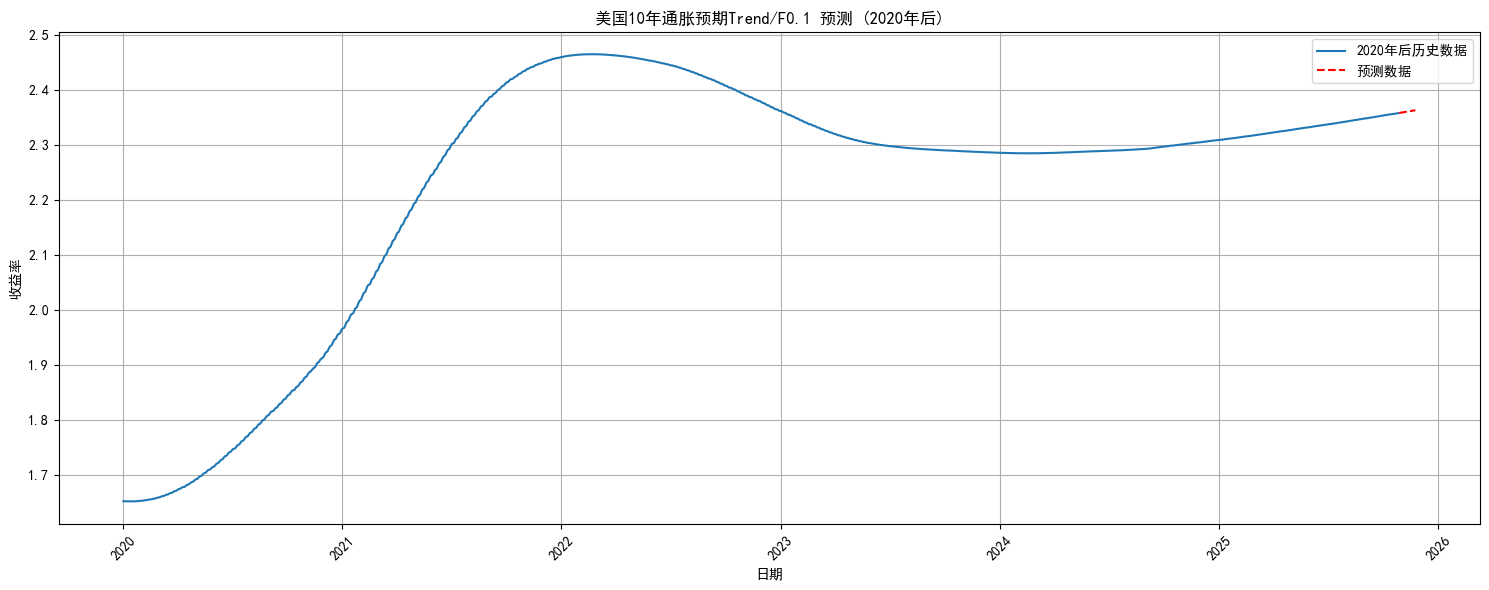

In [6]:
# 获取最后一个日期
last_date = pd.to_datetime(sheet['Date'].iloc[-1])

# 生成未来21个工作日
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')[:20]  # 使用'B'表示工作日,并取前21天

# 获取最后21个历史值用于线性回归
last_values = sheet['美国10年通胀预期Trend/F0.1'].tail(20).values
x = np.arange(len(last_values))
y = last_values.astype(float)  # 确保y值为浮点数类型

# 进行线性回归
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# 预测未来21个值
future_x = np.arange(len(last_values), len(last_values) + len(future_dates))
future_values = p(future_x)

# 创建预测数据框
future_df = pd.DataFrame({
    'Date': future_dates,
    '美国10年通胀预期Trend/F0.1': future_values
})

# 合并历史数据和预测数据
sheet_with_predictions = pd.concat([sheet, future_df], ignore_index=True)

# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2020-01-01']

# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(sheet_2020['Date'], sheet_2020['美国10年通胀预期Trend/F0.1'], label='2020年后历史数据')
plt.plot(future_df['Date'], future_df['美国10年通胀预期Trend/F0.1'], 'r--', label='预测数据')
plt.title('美国10年通胀预期Trend/F0.1 预测 (2020年后)')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/美国10年通胀预期Non-Trend_F0.1_合并数据.xlsx', sheet_name='Sheet1')
sheet_non_trend.head(2)

,Date,真实值,预测值
0,2025/11/24,NaN,0.0139
1,2025/11/21,NaN,0.0212


In [8]:
# 将Date列转换为datetime64[ns]格式
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])


sheet_non_trend

,Date,真实值,预测值
0,2025-11-24,NaN,0.0139
1,2025-11-21,NaN,0.0212
2,2025-11-20,NaN,0.0221
3,2025-11-19,NaN,0.0241
4,2025-11-18,NaN,0.0211
...,...,...,...
681,2023-03-07,0.0493,NaN
682,2023-03-06,0.1587,NaN
683,2023-03-03,0.1880,NaN
684,2023-03-02,0.1474,NaN


In [9]:
merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值']], 
    future_df[['Date', '美国10年通胀预期Trend/F0.1']], 
    on='Date',
    how='outer'
)

In [10]:
# 删除包含空值的行
merged_df = merged_df.dropna()

# 计算最终的
merged_df['美国10年通胀预期'] = merged_df['预测值'] + merged_df['美国10年通胀预期Trend/F0.1']


merged_df.head() 

,Date,预测值,美国10年通胀预期Trend/F0.1,美国10年通胀预期
666,2025-10-28,0.0230,2.358066,2.381066
667,2025-10-29,0.0213,2.358325,2.379625
668,2025-10-30,0.0243,2.358583,2.382883
669,2025-10-31,0.0245,2.358841,2.383341
670,2025-11-03,0.0251,2.359100,2.384200


---

In [11]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '美国10年通胀预期']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '美国10年通胀预期']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')

# 获取最后一个有主焦煤价格/临汾值的行
last_price_row = sheet_data_2023_shizhi.iloc[-1]
last_price_date = pd.to_datetime(last_price_row['Date'])
last_price = last_price_row['实际值']
# 创建新行,日期为最后一个有值日期的后一天
new_row = pd.DataFrame({
    'Date': [last_price_date + pd.Timedelta(days=1)],
    '实际值': [np.nan],
    '美国10年通胀预期': [last_price]
})
# 将新行添加到forecast中
merged_df_shizhi = pd.concat([new_row, merged_df_shizhi])


merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/美国10年通胀预期_合并数据.xlsx', index=False,float_format='%.2f')

merged_df_shizhi.head()

,Date,实际值,美国10年通胀预期
724,2025/11/24,NaN,2.376875
723,2025/11/21,NaN,2.383917
722,2025/11/20,NaN,2.384559
721,2025/11/19,NaN,2.386300
720,2025/11/18,NaN,2.383042


In [12]:
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
monthly_df_shizhi.to_excel('eta/美国10年通胀预期_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head(2)

,Date,实际值,美国10年通胀预期
0,2025/11/30,NaN,2.376875
1,2025/10/31,2.28,2.383341


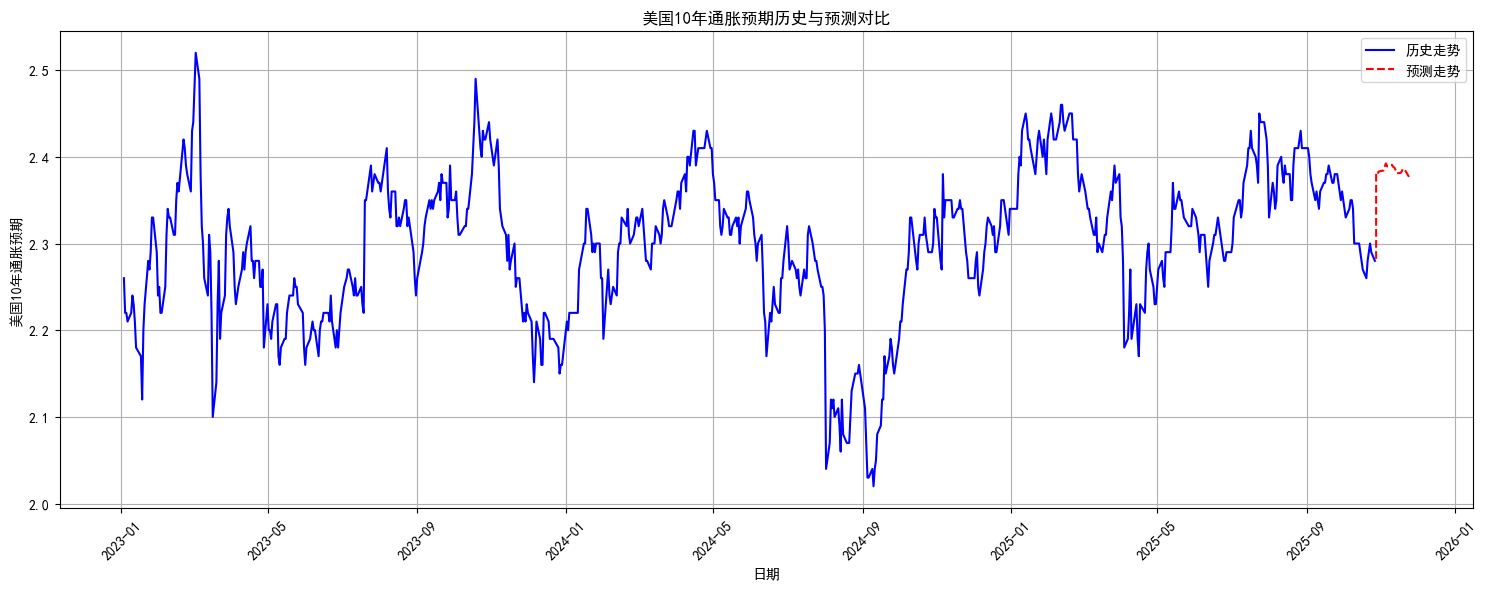

In [13]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))

# 筛选2020年之后的数据
merged_df_shizhi_2020 = merged_df_shizhi[merged_df_shizhi['Date'] >= '2023-01-01']

# 绘制历史数据
plt.plot(merged_df_shizhi_2020['Date'], merged_df_shizhi_2020['实际值'], label='历史走势', color='blue')

# 添加垂直分隔线,标记历史数据和预测数据的分界点
#last_historical_date = merged_df_shizhi_2020['Date'].iloc[-1]
#plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='历史/预测分界线')

# 绘制预测数据
plt.plot(merged_df_shizhi['Date'], merged_df_shizhi['美国10年通胀预期'], label='预测走势', color='red', linestyle='--')

plt.title('美国10年通胀预期历史与预测对比')
plt.xlabel('日期')
plt.ylabel('美国10年通胀预期')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

In [14]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '美国10年通胀预期Trend/F0.1']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, future_df, on='Date', how='outer')
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/美国10年通胀预期Trend_F0.1_合并数据.xlsx', index=False,float_format='%.5f')

# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')
monthly_df_trend.to_excel('eta/美国10年通胀预期Trend_F0.1_月度数据.xlsx', index=False, float_format='%.5f')

In [15]:
merged_df_trend.head()

,Date,实际值,美国10年通胀预期Trend/F0.1
724,2025-11-24,NaN,2.362975
723,2025-11-21,NaN,2.362717
722,2025-11-20,NaN,2.362459
721,2025-11-19,NaN,2.362200
720,2025-11-18,NaN,2.361942


---

In [16]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "美国10年通胀预期Trend/F0.1"

# 调用函数更新数据
success = update_excel_data(merged_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "美国10年通胀预期"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "美国10年通胀预期Trend/F0.1"

# 调用函数更新数据
success = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [19]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "美国10年通胀预期"

# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
